## Part 2: Advanced Techniques

In [95]:
import nltk
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 100)
import string
import re
#from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
import gensim
import gensim.downloader as api

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

import matplotlib.pyplot as plt
from IPython.display import IFrame

In [9]:
messages = pd.read_csv('data/spam.csv', encoding='latin-1')

In [10]:
messages.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives around here though",NaN,NaN,NaN


In [11]:
messages = messages.drop(labels= ["Unnamed: 2", 
                                  "Unnamed: 3",
                                  "Unnamed: 4"],
                        axis=1)

In [12]:
messages.columns = ["label", "text"]

In [13]:
messages.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


#### Check missing values and class imbalances

In [14]:
messages['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [15]:
print("number of nulls in labels: {}".format(
    messages['label'].isnull().sum()))
print("number of nulls in text: {}".format(
    messages['text'].isnull().sum()))

number of nulls in labels: 0
number of nulls in text: 0


#### Remove punctuation

In [16]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text

messages['text_clean'] = messages['text'].apply(
lambda x : remove_punct(x))

messages.head(3)

,label,text,text_clean
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",Go until jurong point crazy Available only in bugis n great world la e buffet Cine there got amo...
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005 Text FA to 87121 to receive e...


#### Tokenize

In [18]:
def tokenize(text_clean):
    tokens = re.split('\W+', text_clean)
    return tokens

messages['text_tokenized'] = messages['text_clean'].apply(
lambda x : tokenize(x.lower()))

messages.head(3)

,label,text,text_clean,text_tokenized
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",Go until jurong point crazy Available only in bugis n great world la e buffet Cine there got amo...,"[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, ci..."
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005 Text FA to 87121 to receive e...,"[free, entry, in, 2, a, wkly, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, to..."


#### Remove Stopwords

In [19]:
stopwords = nltk.corpus.stopwords.words('english')

In [20]:
def remove_stopwords(tokenized_text):
    text = [word for word in tokenized_text if word not in stopwords.words('english')]
    
    return text

messages['text_nostop'] = messages['text_tokenized'].apply(
    lambda x : remove_stopwords(x))

messages.head(3)


AttributeError: 'list' object has no attribute 'words'

#### Vectorizing using TF-IDF

In [21]:
# Redifine text prep function to do everything in one go:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

In [22]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(messages['text'])
print(X_tfidf.shape)
print(tfidf_vect.get_feature_names())

(5572, 9395)
['', '0', '008704050406', '0089my', '0121', '01223585236', '01223585334', '0125698789', '02', '020603', '0207', '02070836089', '02072069400', '02073162414', '02085076972', '020903', '021', '050703', '0578', '06', '060505', '061104', '07008009200', '07046744435', '07090201529', '07090298926', '07099833605', '071104', '07123456789', '0721072', '07732584351', '07734396839', '07742676969', '07753741225', '0776xxxxxxx', '07786200117', '077xxx', '078', '07801543489', '07808', '07808247860', '07808726822', '07815296484', '07821230901', '0784987', '0789xxxxxxx', '0794674629107880867867', '0796xxxxxx', '07973788240', '07xxxxxxxxx', '0800', '08000407165', '08000776320', '08000839402', '08000930705', '08000938767', '08001950382', '08002888812', '08002986030', '08002986906', '08002988890', '08006344447', '0808', '08081263000', '08081560665', '0825', '0844', '08448350055', '08448714184', '0845', '08450542832', '08452810071', '08452810073', '08452810075over18s', '0870', '08700621170150p

In [23]:
# How is the output of TfidfVectorizer stored?
X_features = pd.DataFrame(X_tfidf.toarray())
X_features.head(3)

,0,1,2,3,4,5,6,7,8,9,...,9385,9386,9387,9388,9389,9390,9391,9392,9393,9394
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Random Forest benchmark model 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X_features, messages['label'], test_size=0.2)

In [25]:
# Create and teain the model 
rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train)

In [26]:
# Make prerf_modeldelons
y_pred = rf_model.predict(X_test)

In [27]:
# Evaluate the model based on precision and recall scores
precision = precision_score(y_test, y_pred, pos_label='spam')
recall = recall_score(y_test, y_pred, pos_label='spam')
print("Precision: {} / Recall: {}".format(round(
precision, 3), round(recall, 3)))
print("""Conclusion: based on recall of {} the model is not aggressive enough in identifying spam""".format(round(recall, 3)))

Precision: 1.0 / Recall: 0.783
Conclusion: based on recall of 0.783 the model is not aggressive enough in identifying spam


#### Word2vec using skip-gram method
*You should know a word by the company it keeps...*
**Some other options:**
- `glove-twitter-{25/50/100/200}`
- `glove-wiki-gigaword-{50/200/300}`
- `word2vec-google-news-300`
- `word2vec-ruscorpa-news-300`

In [28]:
#!pip install -U gensim

In [29]:
#import gensim.downloader as api

In [30]:
wiki_embeddings = api.load('glove-wiki-gigaword-100')

In [31]:
# Usage example: expolore tghe word vecto for 'king'
wiki_embeddings['king']

array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
       -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
       -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
       -0.58324 ,  0.66869 , -0.23122 , -0.95855 ,  0.28262 , -0.078848,
        0.75315 ,  0.26584 ,  0.3422  , -0.33949 ,  0.95608 ,  0.065641,
        0.45747 ,  0.39835 ,  0.57965 ,  0.39267 , -0.21851 ,  0.58795 ,
       -0.55999 ,  0.63368 , -0.043983, -0.68731 , -0.37841 ,  0.38026 ,
        0.61641 , -0.88269 , -0.12346 , -0.37928 , -0.38318 ,  0.23868 ,
        0.6685  , -0.43321 , -0.11065 ,  0.081723,  1.1569  ,  0.78958 ,
       -0.21223 , -2.3211  , -0.67806 ,  0.44561 ,  0.65707 ,  0.1045  ,
        0.46217 ,  0.19912 ,  0.25802 ,  0.057194,  0.53443 , -0.43133 ,
       -0.34311 ,  0.59789 , -0.58417 ,  0.068995,  0.23944 , -0.85181 ,
        0.30379 , -0.34177 , -0.25746 , -0.031101, -0.16285 ,  0.45169 ,
       -0.91627 ,  0.64521 ,  0.73281 , -0.22752 , 

In [32]:
# Find the words most similar to 'king' based on the trained word vectors
wiki_embeddings.most_similar('king')

[('prince', 0.7682329416275024),
 ('queen', 0.7507690787315369),
 ('son', 0.7020887732505798),
 ('brother', 0.6985775232315063),
 ('monarch', 0.6977890729904175),
 ('throne', 0.691999077796936),
 ('kingdom', 0.6811410188674927),
 ('father', 0.680202841758728),
 ('emperor', 0.6712858080863953),
 ('ii', 0.6676074266433716)]

In [33]:
wiki_embeddings.distances('king', 'son')

array([0.653131  , 0.70983773, 0.8534338 ], dtype=float32)

In [34]:
# Usage example of alternative data cleaning library
data = messages[['label', 'text']].copy() # Take a copy of orginal dataset

In [35]:
data['text_clean'] = data['text'].apply(
lambda x: gensim.utils.simple_preprocess(x))

data.head(3)

,label,text,text_clean
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...","[go, until, jurong, point, crazy, available, only, in, bugis, great, world, la, buffet, cine, th..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,"[free, entry, in, wkly, comp, to, win, fa, cup, final, tkts, st, may, text, fa, to, to, receive,..."


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
data['text_clean'], data['label'], test_size=0.2)

In [37]:
# Train word2vec model
w2v_model = gensim.models.Word2Vec(X_train, 
                                   size=100, 
                                   window=5,
                                   min_count=2)


In [38]:
w2v_model.wv['king']

array([-0.03911388, -0.04009522, -0.07687595, -0.02443327,  0.02812677,
       -0.01882526, -0.05820478, -0.01629503,  0.01178009,  0.03515982,
        0.0241134 ,  0.08079547, -0.09375853, -0.01367643,  0.0158078 ,
       -0.03552073, -0.10317755, -0.01194861, -0.06536233, -0.22691467,
       -0.00434199,  0.12218717, -0.12395405,  0.08594593,  0.02655452,
       -0.09435704, -0.00153048,  0.0109334 , -0.06483617, -0.12558955,
       -0.04572552,  0.04979856,  0.00427199, -0.05482119,  0.03492249,
        0.03936573, -0.11956096,  0.00668365,  0.06120979,  0.12317777,
        0.06517312, -0.02245472,  0.03035253,  0.04291409, -0.00513079,
        0.12531349,  0.08406349,  0.02054335, -0.03707476,  0.01791471,
        0.10744014,  0.09883872,  0.04896588, -0.07060183,  0.02240005,
       -0.05082726, -0.04635407,  0.11273821, -0.04660477,  0.04961576,
        0.01049941, -0.09935628,  0.00966514, -0.04948821,  0.07268967,
       -0.0124074 ,  0.06896804,  0.03281971, -0.0124341 , -0.00

In [39]:
w2v_model.wv.most_similar('king')

[('great', 0.9990748763084412),
 ('good', 0.9990189075469971),
 ('is', 0.9989975690841675),
 ('smile', 0.9989945888519287),
 ('was', 0.9989938735961914),
 ('well', 0.9989907741546631),
 ('off', 0.998990535736084),
 ('birthday', 0.998979926109314),
 ('take', 0.9989798069000244),
 ('use', 0.9989769458770752)]

In [40]:
# Here is a list of words we learned from, i.e. these words appeared at leats twice
len(w2v_model.wv.index2word)

3399

In [41]:
# Generate aggregated sentence vectors based on the word vectors
# for each word in the sentence
w2v_vect = np.array([np.array([w2v_model.wv[i]
                              for i in ls
                              if i in w2v_model.wv.index2word])
                    for ls in X_test])

In [42]:
# Why is the length of the sentence different than the legth
# of the sentece vector?
for i, v in enumerate(w2v_vect):
    print(len(X_test.iloc[i]), len(v))

30 29
12 12
6 5
8 7
7 7
6 6
23 23
25 19
17 16
25 22
25 22
8 8
19 19
14 14
30 29
6 5
20 20
7 7
6 5
11 11
23 20
11 11
19 17
13 12
19 16
21 20
14 11
19 19
23 20
28 26
28 25
14 13
5 5
6 4
31 31
4 4
10 9
19 18
11 11
6 5
1 1
27 24
8 8
7 7
10 10
13 13
28 27
4 3
20 16
5 5
19 17
5 4
29 27
23 22
12 11
18 14
8 7
21 20
21 21
5 5
24 22
18 15
26 23
12 11
14 13
7 7
2 2
14 14
18 16
3 3
13 13
6 6
9 9
2 2
9 9
19 13
37 35
1 1
24 23
28 25
14 13
19 15
15 12
1 1
22 20
11 9
6 6
17 16
7 7
6 6
8 8
5 5
19 16
15 15
23 21
20 19
13 12
26 24
11 10
4 4
35 35
5 3
15 12
10 10
8 8
6 4
4 3
6 6
2 2
9 9
11 10
8 8
18 18
4 4
15 15
10 10
9 9
7 5
4 3
10 10
4 4
24 22
7 6
19 16
10 9
9 9
6 6
11 10
7 7
13 12
7 6
7 5
36 21
28 27
15 14
23 23
2 2
8 7
4 1
6 6
7 7
20 17
17 15
6 4
8 7
5 4
3 3
17 17
20 20
21 18
46 42
27 20
21 19
19 13
34 30
15 12
12 10
24 20
11 10
23 19
10 9
8 7
16 13
15 15
13 11
10 8
18 16
7 7
13 12
23 22
8 8
6 5
23 20
15 15
5 5
12 11
16 12
27 27
13 13
23 22
8 5
8 8
8 5
9 9
8 8
6 6
6 6
8 8
16 16
28 21
8 3
5 5
15 15
21 

In [43]:
# Compute sentence vectors by averaging the word vectors
# for the words contained in the sentence
w2v_vect_avg = []
for vect in w2v_vect:
    if len(vect) != 0:
        w2v_vect_avg.append(vect.mean(axis=0))
    else:
        w2v_vect_avg.append(np.zeros(100))

In [44]:
# Are the lengths consitent now? Yes!
for i, v in enumerate(w2v_vect_avg):
    print(len(X_test.iloc[i]), len(v))

30 100
12 100
6 100
8 100
7 100
6 100
23 100
25 100
17 100
25 100
25 100
8 100
19 100
14 100
30 100
6 100
20 100
7 100
6 100
11 100
23 100
11 100
19 100
13 100
19 100
21 100
14 100
19 100
23 100
28 100
28 100
14 100
5 100
6 100
31 100
4 100
10 100
19 100
11 100
6 100
1 100
27 100
8 100
7 100
10 100
13 100
28 100
4 100
20 100
5 100
19 100
5 100
29 100
23 100
12 100
18 100
8 100
21 100
21 100
5 100
24 100
18 100
26 100
12 100
14 100
7 100
2 100
14 100
18 100
3 100
13 100
6 100
9 100
2 100
9 100
19 100
37 100
1 100
24 100
28 100
14 100
19 100
15 100
1 100
22 100
11 100
6 100
17 100
7 100
6 100
8 100
5 100
19 100
15 100
23 100
20 100
13 100
26 100
11 100
4 100
35 100
5 100
15 100
10 100
8 100
6 100
4 100
6 100
2 100
9 100
11 100
8 100
18 100
4 100
15 100
10 100
9 100
7 100
4 100
10 100
4 100
24 100
7 100
19 100
10 100
9 100
6 100
11 100
7 100
13 100
7 100
7 100
36 100
28 100
15 100
23 100
2 100
8 100
4 100
6 100
7 100
20 100
17 100
6 100
8 100
5 100
3 100
17 100
20 100
21 100
46 100
27 100

#### Doc2vec - shallow two-layer neural network

In [45]:
# Create tagged document objects to prepare to train the model
tagged_docs = [gensim.models.doc2vec.TaggedDocument(v, [i]) 
                for i, v in enumerate(X_train)]
tagged_docs[0]

TaggedDocument(words=['well', 'might', 'not', 'come', 'then'], tags=[0])

In [46]:
# Train a basic doc2vec model
d2v_model = gensim.models.Doc2Vec(tagged_docs, 
                                 vector_size=100,
                                 window=5,
                                 min_count=2)

In [47]:
d2v_model.infer_vector(['i', 'am', 'learning', 'NLP'])

array([-3.4329267e-03,  1.1493620e-03, -4.3692780e-03, -3.8762684e-03,
        5.3306255e-03,  3.3913353e-03, -6.8941317e-03, -4.0711081e-03,
       -6.9685522e-03,  2.3409985e-03,  4.9349049e-04,  9.7126607e-03,
       -1.1850455e-02, -2.5228821e-03,  5.8149216e-03, -4.3249852e-03,
       -1.3082142e-02,  3.1835057e-03, -3.7183829e-03, -1.4888778e-02,
       -3.1699305e-03,  1.3063429e-02, -9.4122626e-03,  4.3626605e-03,
        4.0642750e-03, -7.6887072e-03,  1.4477916e-03,  1.3720084e-03,
       -7.7421409e-03, -9.7319940e-03, -2.5011674e-03,  1.7078815e-04,
        8.2844906e-03, -2.5584309e-03,  7.1786955e-05,  5.9892093e-03,
       -4.2676535e-03,  1.2179273e-03,  7.4710520e-03,  8.9897020e-03,
        1.2496637e-02, -2.0088153e-03, -1.3846940e-03,  3.4028178e-03,
        1.0916920e-03,  6.7741601e-03,  1.1113595e-02,  3.0315367e-03,
        1.8098485e-04,  5.8115571e-04,  1.5843909e-02,  7.8402534e-03,
        8.9254240e-03, -7.0428587e-03, -9.5757510e-04, -1.2052238e-03,
      

#### How to prepare document vectors for modeling

In [48]:
d2v_model.infer_vector(['convert', 'words', 'to', 'vectors'])[:5]

array([ 0.00283626,  0.00323133, -0.00671095,  0.00274699,  0.00416542],
      dtype=float32)

In [49]:
d2v_model.infer_vector(['convert', 'to', 'words', 'vectors'])[:5]

array([-0.00346771,  0.00155263, -0.00987448,  0.00106783,  0.01128314],
      dtype=float32)

In [50]:
# How to prepare these vectors to be used in a machine learning model/
vectors = [[d2v_model.infer_vector(words)] for words in X_test]

In [51]:
len(vectors)

1115

#### Recurrent Neural Network
Pattern matching through the connection of many very simple
functions to create one very powerful function; **this function
has an understanding of the data's sequential nature
(using feedback loops that form a sense of memory**)

In [52]:
IFrame("images/rnn.pdf'", width=700, height=300)

In [53]:
 data.head()

,label,text,text_clean
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...","[go, until, jurong, point, crazy, available, only, in, bugis, great, world, la, buffet, cine, th..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,"[free, entry, in, wkly, comp, to, win, fa, cup, final, tkts, st, may, text, fa, to, to, receive,..."
3,ham,U dun say so early hor... U c already then say...,"[dun, say, so, early, hor, already, then, say]"
4,ham,"Nah I don't think he goes to usf, he lives around here though","[nah, don, think, he, goes, to, usf, he, lives, around, here, though]"


In [100]:
messages = pd.read_csv('data/spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'],
                                                    labels, test_size=0.2)

In [101]:
labels

array([0, 0, 1, ..., 0, 0, 0])

In [102]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [103]:
# Use that tokenizer to transform the text messages
# in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [104]:
# Numeric representation of a single message... 
# Note: variable length
X_train_seq[0]

[184,
 209,
 290,
 291,
 1,
 17,
 2579,
 3781,
 28,
 284,
 3782,
 49,
 18,
 1124,
 299,
 129,
 415,
 479]

In [112]:
# Need to pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50) # adding 0 if not long enought
X_test_seq_padded = pad_sequences(X_test_seq, 50) # adding 0 if not long enought

In [113]:
type(X_train_seq_padded)

numpy.ndarray

In [114]:
# What do these padded sequences look like?
X_train_seq_padded[88]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0, 2613, 2614,
          2,   33,    9,    8,   21,   47], dtype=int32)

#### Building the RNN model,m yeah!

In [120]:
# import keras.backend as K
# from keras.layers import Dense, Embedding, LSTM
# from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [121]:
# Construct a simple RNN model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          252448    
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 261,857
Trainable params: 261,857
Non-trainable params: 0
_________________________________________________________________


In [122]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

# model.compile(optimizer='adam', 
#               loss='binary_crossentropy',
#               metrics=['accuracy', precision_m, recall_m])

In [123]:
# Fit the model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))


# history = model.fit(X_train_seq_padded,
#                     y_train,
#                     batch_size=32,
#                     epochs=1,
#                     validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 3s 22ms/step - loss: 0.2806 - accuracy: 0.9103 - precision_m: 0.4593 - recall_m: 0.3522 - val_loss: 0.0918 - val_accuracy: 0.9731 - val_precision_m: 1.0000 - val_recall_m: 0.8160
Epoch 2/10
140/140 [==============================] - 3s 18ms/step - loss: 0.0328 - accuracy: 0.9915 - precision_m: 0.9590 - recall_m: 0.9317 - val_loss: 0.0610 - val_accuracy: 0.9776 - val_precision_m: 0.9671 - val_recall_m: 0.8890
Epoch 3/10
140/140 [==============================] - 3s 22ms/step - loss: 0.0095 - accuracy: 0.9969 - precision_m: 0.9896 - recall_m: 0.9775 - val_loss: 0.0673 - val_accuracy: 0.9803 - val_precision_m: 0.9459 - val_recall_m: 0.9305
Epoch 4/10
140/140 [==============================] - 3s 20ms/step - loss: 0.0041 - accuracy: 0.9993 - precision_m: 0.9786 - recall_m: 0.9751 - val_loss: 0.0823 - val_accuracy: 0.9803 - val_precision_m: 0.9736 - val_recall_m: 0.8988
Epoch 5/10
140/140 [==============================] - 3s 18ms/step -

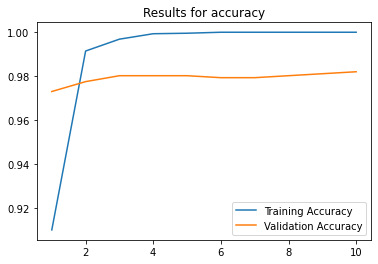

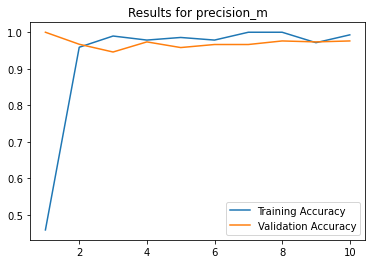

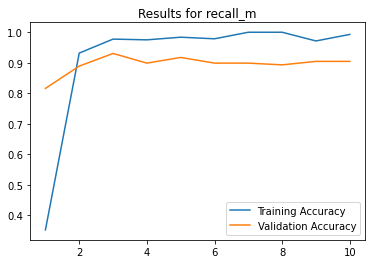

In [124]:
for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()

#### Comparing different models